Nesse notebook, faremos todas as manipulações necessárias para treinarmos os nossos modelos.

# Setup dos dados iniciais
### Instalação de bibliotecas e imports
Na célula abaixo, importamos e instalamos as bibliotecas necessárias para a manipulação dos dados. 

In [ ]:
!pip install -U -q PyDrive

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelBinarizer
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

### Autenticação para acesso aos dados
Na célula abaixo, abrimos um popup do Google para fazer a autenticação no Google Drive.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Download dos dados para esta máquina virtual
Baixamos a base de dados no colab para conseguirmos manipulá-la.

In [ ]:
downloaded = drive.CreateFile({'id': '1BK5Rjc5yYNojUvIyx4VjIKd3mHWzFl8J'})
downloaded.GetContentFile('data.csv')

### Carregando os dados baixados no dataframe
Armazenamos a base de dados em um dataframe do Pandas e filtramos para obter apenas uma safra.

In [ ]:
# Dados lidos do arquvio csv
df = pd.read_csv('data.csv')

# Definição de dataframe que será utilizado na seção de mapeamento de jornada do usuário
new_df = df.copy()

# Filtrando a base de dados com um único mês
last_month = df.anomes == 202204
df = df[last_month]

# Mostrando primeiros registros do Dataframe
df.head()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
0,202204,cb12b6e129afbe2cc514ca053b8914992b4c8f73087cb9...,6667.88,1360.96,NaN,446.0,1.0,NaN,8.0,NaN,7.0,"1650,00",A,NaN,NaN,NaN
4,202204,19039d3944f2f19e53debd4ca61514d185b53e3f3d52dc...,NaN,NaN,NaN,148.0,NaN,NaN,NaN,NaN,1.0,"750,00",NaN,NaN,NaN,NaN
18,202204,4e88066de269003d043093fa2253327f9823625de498c3...,1599.31,64.02,NaN,134.0,1.0,NaN,3.0,NaN,2.0,"1100,00",H,NaN,NaN,NaN
30,202204,d8ed0b200dfdf8ea0a804fbcc00d05415224a5938bcff4...,10921.59,1264.50,NaN,334.0,2.0,NaN,12.0,NaN,5.0,"2050,00",D,NaN,NaN,NaN
35,202204,49a351b1547a451f103c0c0f0a047f062d6f00538b4a3a...,305.47,1400.00,NaN,403.0,1.0,NaN,6.0,NaN,2.0,"4400,00",A,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 851414 entries, 0 to 11886317
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   anomes          851414 non-null  int64  
 1   num_cpf_hash    851414 non-null  object 
 2   vlr_credito     464590 non-null  float64
 3   vlr_saldo       435627 non-null  float64
 4   num_atend_atrs  521 non-null     float64
 5   vlr_score       851116 non-null  float64
 6   num_produtos    435627 non-null  float64
 7   num_atend       1550 non-null    float64
 8   qtd_oper        464590 non-null  float64
 9   qtd_reclm       57 non-null      float64
 10  qtd_restr       604557 non-null  float64
 11  vlr_renda       851414 non-null  object 
 12  cod_rating      435627 non-null  object 
 13  ind_atrito      216 non-null     float64
 14  ind_engaj       147745 non-null  float64
 15  ind_novo_cli    170899 non-null  float64
dtypes: float64(12), int64(1), object(3)
memory usage: 110.

In [ ]:
df.describe(include="object")

,num_cpf_hash,vlr_renda,cod_rating
count,851414,851414,435627
unique,851414,2085,10
top,cb12b6e129afbe2cc514ca053b8914992b4c8f73087cb9...,"4300,00",A
freq,1,50282,330229


# Manipulação dos dados das colunas da base de dados geral
##### Preenchemos os valores vazios das colunas do dataframe e tratamos dados que estavam com a tipagem errada.


Precisamos transformar os dados da coluna "vlr_renda" de string para float para conseguirmos utilizar essa coluna nos modelos de predição, visto que estes não podem ser treinados com valores categóricos.



In [ ]:
df["vlr_renda"] = df["vlr_renda"].str.replace(',','.')
df["vlr_renda"] = df["vlr_renda"].astype(float)

Nas seguinte células, transformamos os valores NaN das colunas em 0, visto que os modelos não podemos ser treinados com colunas que possuem valores vazios.

In [ ]:
df['ind_atrito'] = df['ind_atrito'].fillna(0)

In [ ]:
df['ind_engaj'] = df['ind_engaj'].fillna(0)

In [ ]:
df['ind_novo_cli'] = df['ind_novo_cli'].fillna(0)

In [ ]:
df['num_atend'] = df['num_atend'].fillna(0)

In [ ]:
df['num_atend_atrs'] = df['num_atend_atrs'].fillna(0)

In [ ]:
df['qtd_reclm'] = df['qtd_reclm'].fillna(0) 

# Divisão da tabela entre clientes e não 
Como estamos fazendo as manipulações necessárias para a criação de três modelos (atritado, engajado e novo cliente), dividimos o nosso dataframe em 2: clientes e não clientes.







*   Modelo de atritado -> utiliza o dataframe de cliente
*   Modelo de engajado -> utiliza o dataframe de cliente
*   Modelo de novo cliente -> utiliza o dataframe de não cliente






In [ ]:
client = df[df.cod_rating.notna()]
not_client = df[df.cod_rating.isna()]

#Visualização gráfica de hipóteses
Nessa seção, pensamos em algumas hipóteses e criamos gráficos para comprovar ou não a sua veracidade.

##Hipótese 1
Clientes com o score mais alto possuem um valor de saldo no banco pan maior (Hipótese não comprovada).

In [ ]:
fig = px.scatter(client.sample(10000), x = "vlr_score", y = "vlr_saldo")
fig.show()

##Hipótese 2
O banco pan possui mais clientes com classificação A do que H (Comprovada).


In [ ]:
client.cod_rating.describe()

count     435627
unique        10
top            A
freq      330229
Name: cod_rating, dtype: object

##Hipótese 3
Como o banco atende a clientes de baixa renda, acreditamos que eles contratem vários produtos com baixos valores (Comprovada). 


In [ ]:
fig = px.scatter(client.sample(10000), x = "qtd_oper", y = "vlr_saldo")
fig.show()

#Remoção de colunas
Nessa seção, removemos as colunas que não utilizaremos nos nossos modelos.

## Remoção das colunas que não iremos utilizar da tabela de clientes

In [ ]:
client = client.drop('cod_rating', axis=1)

In [ ]:
client = client.drop('ind_novo_cli', axis=1)

In [ ]:
client = client.drop('num_cpf_hash', axis=1)

In [ ]:
client = client.drop('anomes', axis=1)

## Remoção das colunas que não iremos utilizar da tabela de não clientes

In [ ]:
not_client = not_client.drop('vlr_saldo', axis=1)

In [ ]:
not_client = not_client.drop('cod_rating', axis=1)

In [ ]:
not_client = not_client.drop('ind_atrito', axis=1)

In [ ]:
not_client = not_client.drop('ind_engaj', axis=1)

In [ ]:
not_client = not_client.drop('num_cpf_hash', axis=1)

In [ ]:
not_client = not_client.drop('num_produtos', axis=1)

In [ ]:
not_client = not_client.drop('anomes', axis=1)

In [ ]:
not_client = not_client.drop('qtd_oper', axis=1)

# Remoção das linhas com valores vazios (NaN)
Aqui, removemos as linhas que possuem alguma coluna com valores vazios. 

Esse passo é necessário, visto que não conseguimos treinar os modelos com colunas que possuem valores NaN (valores vazios).

In [ ]:
client = client.dropna()
not_client = not_client.dropna()

#Visualização dos dados
Nessa seção, visualizamos os dados de diferentes maneiras para entender os padrões de cada coluna e quais fazem mais sentido para o nosso modelo.

##Tabela completa:

In [ ]:
df.describe()

,anomes,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj,ind_novo_cli
count,851414.0,4.645900e+05,4.356270e+05,851414.000000,851116.000000,435627.000000,851414.000000,464590.000000,851414.000000,604557.000000,851414.000000,851414.000000,851414.000000,851414.000000
mean,202204.0,3.441006e+04,5.749114e+03,0.000682,440.869032,2.615591,0.002493,12.625160,0.000067,3.044356,3451.888682,0.000254,0.173529,0.200724
std,0.0,7.105371e+04,1.031318e+04,0.029612,205.964872,2.667028,0.064932,11.051452,0.008182,3.792966,6206.799900,0.015926,0.378704,0.400542
min,202204.0,0.000000e+00,1.000000e-02,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,202204.0,3.545455e+03,9.993000e+02,0.000000,304.000000,1.000000,0.000000,5.000000,0.000000,1.000000,1250.000000,0.000000,0.000000,0.000000
50%,202204.0,1.545219e+04,2.424330e+03,0.000000,402.000000,2.000000,0.000000,10.000000,0.000000,2.000000,1750.000000,0.000000,0.000000,0.000000
75%,202204.0,3.653325e+04,6.712735e+03,0.000000,575.000000,3.000000,0.000000,17.000000,0.000000,4.000000,4250.000000,0.000000,0.000000,0.000000
max,202204.0,1.034811e+07,1.666399e+06,6.000000,1000.000000,96.000000,9.000000,265.000000,1.000000,217.000000,550750.000000,1.000000,1.000000,1.000000


##Tabela clientes:

In [ ]:
client.describe()

,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj
count,1.858800e+05,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.00000,185880.000000,185880.000000,185880.000000
mean,4.112444e+04,5565.679638,0.000936,375.723268,2.506472,0.003578,14.076001,0.000151,3.30857,3855.009415,0.000522,0.340515
std,6.715217e+04,9556.055169,0.032459,143.455257,2.237989,0.074894,10.516395,0.012272,3.74673,6151.065231,0.022838,0.473884
min,0.000000e+00,0.010000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,250.000000,0.000000,0.000000
25%,7.896820e+03,880.052500,0.000000,285.000000,1.000000,0.000000,7.000000,0.000000,1.00000,1350.000000,0.000000,0.000000
50%,2.074161e+04,2185.470000,0.000000,384.000000,2.000000,0.000000,12.000000,0.000000,2.00000,2200.000000,0.000000,0.000000
75%,4.597636e+04,6191.815000,0.000000,462.000000,3.000000,0.000000,18.000000,0.000000,4.00000,4300.000000,0.000000,1.000000
max,3.699561e+06,741055.970000,2.000000,973.000000,88.000000,5.000000,265.000000,1.000000,110.00000,360200.000000,1.000000,1.000000


##Tabela não clientes:

In [ ]:
not_client.describe()

,vlr_credito,num_atend_atrs,vlr_score,num_atend,qtd_reclm,qtd_restr,vlr_renda,ind_novo_cli
count,5.922000e+04,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000,59220.000000
mean,1.116576e+04,0.000152,287.116211,0.000540,0.000017,3.291692,2381.376224,0.276292
std,4.897024e+04,0.013628,133.671909,0.025326,0.004109,3.780653,3443.226629,0.447167
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,350.000000,0.000000
25%,0.000000e+00,0.000000,176.000000,0.000000,0.000000,1.000000,1150.000000,0.000000
50%,9.382750e+02,0.000000,274.000000,0.000000,0.000000,2.000000,1400.000000,0.000000
75%,5.099010e+03,0.000000,376.000000,0.000000,0.000000,4.000000,3500.000000,1.000000
max,7.638867e+06,2.000000,961.000000,2.000000,1.000000,217.000000,193600.000000,1.000000


##  Visualização de Jornada do usuário
Foram coletados 3 CPFs para visualizar a diferença de suas características (colunas) no decorrer das safras.

### Modelos de atritado


In [ ]:
# Coletar o ID do cpf a partir da última safra
df[(df.anomes == 202204) & (df.ind_atrito == 1)].head() 

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
4128,202204,dbcfe0e2b3bb4a3c66b238f9bf2245f3ffbd29c894c251...,3835.65,2054.79,0.0,840.0,1.0,0.0,7.0,0.0,NaN,1350.0,A,1.0,0.0,0.0
5135,202204,b2bfa04664efbce900719013ad19e0f6364d9216b647e0...,50301.02,5044.47,0.0,504.0,4.0,0.0,22.0,1.0,1.0,7050.0,A,1.0,1.0,0.0
80802,202204,e1a1ee51ac30b7b870a239683cdab6e78b5ee6c9284f6e...,NaN,NaN,0.0,546.0,NaN,0.0,NaN,0.0,1.0,1700.0,NaN,1.0,0.0,1.0
215022,202204,85870dad631b67eeed79867beaa047927c26fdcf4b490a...,1818.58,1818.58,0.0,554.0,1.0,0.0,1.0,1.0,NaN,750.0,AA,1.0,0.0,0.0
239415,202204,6ca4d437d8c1319ec9794cd7cce6388fb86fb6f10a13e9...,NaN,NaN,0.0,219.0,NaN,0.0,NaN,0.0,2.0,1400.0,NaN,1.0,0.0,0.0


In [ ]:
# Coletar o número completo do cpf para analisar cada safra
new_df.loc[9269696,'num_cpf_hash']

'100755d913be441cdcd99bee238fab26525e36eddf23aa79dfc1a0a77411de36'

In [ ]:
# Visualização de cada mês de um cpf
new_df[(new_df.num_cpf_hash == 'fe7728cf4b196eedfae889dff044eca220e42c72bb837f158c420649fd738e2d')]

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
1635859,202110,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,68255.25,1309.68,NaN,368.0,1.0,NaN,18.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
6882055,202107,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,60705.58,1330.82,NaN,360.0,1.0,NaN,20.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
7051843,202104,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,44012.30,1319.90,NaN,NaN,1.0,NaN,17.0,1.0,NaN,"5700,00",A,1.0,1.0,NaN
7704859,202106,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,43632.71,1337.35,NaN,394.0,1.0,NaN,16.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
8706658,202203,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,73449.31,1269.91,NaN,407.0,1.0,NaN,20.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
9086870,202112,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,71859.22,1294.65,NaN,366.0,1.0,NaN,19.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
9498466,202204,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,72748.59,1261.37,NaN,388.0,1.0,NaN,20.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
9874605,202108,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,61309.08,1324.16,NaN,276.0,1.0,NaN,18.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
10034226,202111,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,70944.92,1301.85,NaN,NaN,1.0,NaN,18.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN
10345193,202202,fe7728cf4b196eedfae889dff044eca220e42c72bb837f...,70349.24,1277.56,NaN,400.0,1.0,NaN,18.0,NaN,NaN,"5700,00",A,NaN,NaN,NaN


In [ ]:
new_df[(new_df.num_cpf_hash == '0069c06b6016281ff4af4f6b585d89b4efa25c270de9cbf857253db1bd47f3f2')]

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
347983,202108,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,36242.87,5135.11,NaN,670.0,1.0,NaN,52.0,NaN,NaN,"4050,00",A,NaN,NaN,NaN
560220,202202,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,39985.18,4940.95,NaN,575.0,1.0,NaN,24.0,NaN,1.0,"4050,00",A,NaN,NaN,NaN
926769,202204,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,38947.91,4873.36,NaN,523.0,1.0,NaN,23.0,1.0,2.0,"4050,00",A,1.0,NaN,NaN
2080062,202109,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,35324.15,5103.63,NaN,475.0,1.0,NaN,51.0,NaN,2.0,"4050,00",A,NaN,NaN,NaN
2302022,202107,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,34782.94,5163.03,NaN,657.0,1.0,NaN,40.0,NaN,1.0,"4050,00",A,NaN,NaN,NaN
2510792,202203,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,40571.55,4908.88,NaN,575.0,1.0,NaN,22.0,NaN,1.0,"4050,00",A,NaN,NaN,NaN
3304047,202201,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,38040.05,4981.09,NaN,516.0,1.0,NaN,26.0,NaN,2.0,"4050,00",A,NaN,NaN,NaN
4746283,202105,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,34671.39,5220.40,NaN,429.0,1.0,NaN,35.0,NaN,1.0,"4050,00",A,NaN,NaN,NaN
6523131,202104,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,34348.65,5246.76,NaN,410.0,1.0,NaN,52.0,NaN,1.0,"4050,00",A,NaN,NaN,NaN
6837840,202112,0069c06b6016281ff4af4f6b585d89b4efa25c270de9cb...,26131.61,5011.87,NaN,519.0,1.0,NaN,30.0,NaN,1.0,"4050,00",A,NaN,NaN,NaN


In [ ]:
new_df[(new_df.num_cpf_hash == '01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4757a05a706707c406d')]

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
327010,202110,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,NaN,750.69,NaN,NaN,1.0,NaN,NaN,NaN,8.0,"1500,00",HH,NaN,NaN,NaN
456268,202112,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,NaN,750.69,NaN,293.0,1.0,NaN,NaN,NaN,8.0,"1500,00",HH,NaN,NaN,NaN
610291,202202,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,NaN,750.69,NaN,291.0,1.0,NaN,NaN,NaN,8.0,"1500,00",HH,NaN,NaN,NaN
913660,202201,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,NaN,750.69,NaN,295.0,1.0,NaN,NaN,NaN,8.0,"1500,00",HH,NaN,NaN,NaN
1195540,202106,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,0.00,750.69,NaN,156.0,1.0,NaN,7.0,NaN,8.0,"1500,00",HH,NaN,NaN,NaN
1204083,202104,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,1843.30,750.69,NaN,159.0,1.0,NaN,7.0,NaN,8.0,"1500,00",H,NaN,NaN,NaN
1583860,202105,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,1843.31,750.69,NaN,164.0,1.0,NaN,7.0,NaN,8.0,"1500,00",H,NaN,NaN,NaN
1780915,202107,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,0.00,750.69,NaN,NaN,1.0,NaN,7.0,NaN,8.0,"1500,00",HH,NaN,NaN,NaN
2119685,202203,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,NaN,750.69,NaN,280.0,1.0,NaN,NaN,NaN,8.0,"1500,00",HH,NaN,NaN,NaN
2736901,202109,01cf69537ed0cad6e0a3ecb6f6913cf0f1572ee12f64e4...,NaN,750.69,NaN,NaN,1.0,NaN,NaN,NaN,8.0,"1500,00",HH,NaN,NaN,NaN


Os resultados das análises, comparando os três cpfs, foram inconclusivos

### Modelo de Engajado

In [ ]:
# Coletar o ID do cpf a partir da última safra
new_df[(new_df.anomes == 202111) & (new_df.ind_engaj == 1)].head()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
7,202111,27b870469c40b7d8fd925eacdb5be5c9a6c4b66b43e748...,77326.58,5198.53,NaN,NaN,2.0,NaN,20.0,NaN,1.0,"4050,00",A,NaN,1.0,NaN
49,202111,271e6631e1c9022986f85df3ce5c2b6fcf897aeebea5c4...,5725.17,7338.17,NaN,364.0,8.0,NaN,8.0,NaN,NaN,"1500,00",A,NaN,1.0,NaN
87,202111,6f8796a8ef05dbe14cbf5f285e0e26635b5fb09628216d...,22087.87,3722.37,NaN,647.0,4.0,NaN,14.0,NaN,NaN,"4300,00",A,NaN,1.0,NaN
516,202111,69acb7ec254bdfccdbd78169f1550a7271e55c19872f5e...,202268.91,3290.46,NaN,NaN,2.0,NaN,19.0,NaN,5.0,"15050,00",A,NaN,1.0,NaN
699,202111,185f91f4d5712d44dd31650b0e8eae75188e82f7a43052...,17800.55,4371.79,NaN,350.0,3.0,NaN,11.0,NaN,4.0,"1650,00",A,NaN,1.0,NaN


In [ ]:
# Coletar o número do cpf completo pelo ID
new_df.loc[7532135	,'num_cpf_hash']

'81595dfc6a2b6df5fb1a57efa0b54223f37e4c4da1666c0b6170ff25c3eb0697'

In [ ]:
# Visualização de cada mês de um cpf
new_df[(new_df.num_cpf_hash == '00003671431c71ae1a84ec138b63c7a6e465f9616af5ea9ab0c2572da9c2f204')]

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
2416819,202112,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,3811.21,1363.47,NaN,379.0,2.0,NaN,4.0,NaN,3.0,"1550,00",H,NaN,NaN,NaN
2700888,202202,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,NaN,NaN,NaN,383.0,NaN,NaN,NaN,NaN,2.0,"1550,00",NaN,NaN,NaN,1.0
3491253,202201,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,NaN,NaN,NaN,398.0,NaN,NaN,NaN,NaN,2.0,"1550,00",NaN,NaN,NaN,1.0
4319431,202109,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,4004.44,1443.67,NaN,302.0,2.0,NaN,5.0,NaN,3.0,"1550,00",H,NaN,NaN,NaN
6039002,202111,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,4295.58,1443.67,NaN,329.0,2.0,NaN,5.0,NaN,3.0,"1550,00",H,NaN,1.0,NaN
6652141,202107,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,3521.21,1443.67,NaN,287.0,2.0,NaN,6.0,NaN,3.0,"1550,00",H,NaN,NaN,NaN
8586798,202110,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,4156.74,1443.67,NaN,308.0,2.0,NaN,5.0,NaN,3.0,"1550,00",H,NaN,NaN,NaN
9085223,202108,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,3877.10,1443.67,NaN,311.0,2.0,NaN,5.0,NaN,3.0,"1550,00",H,NaN,NaN,NaN
9574747,202203,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,NaN,NaN,NaN,339.0,NaN,NaN,NaN,NaN,2.0,"1550,00",NaN,NaN,NaN,1.0
10375513,202106,00003671431c71ae1a84ec138b63c7a6e465f9616af5ea...,2410.22,1443.67,NaN,325.0,2.0,NaN,6.0,NaN,2.0,"1550,00",G,NaN,NaN,NaN


Os resultados apresentados foram inconclusivos, de acordo com as hipóteses testadas

## Análise dos dados

Iremos selecionar as features que são interessantes para identificar se um cliente é caracterizado como um novo cliente.

In [ ]:
# Nesta variável estamos armazenando os clientes que têm índice 1 na coluna ind_novo_cli
new_client_ind_1 = not_client[not_client.ind_novo_cli == 1]

# Nesta variável estamos armazenando os clientes que têm índice 0 na coluna ind_novo_cli
new_client_ind_0 = not_client[not_client.ind_novo_cli != 1]

### Novo cliente

Relação entre o desejo do banco em ter um cliente (0 = quer como cliente; 1 = não quer como cliente) e o Score do mercado.

In [ ]:
fig = px.bar(y = [new_client_ind_1['vlr_score'].mean(), new_client_ind_0['vlr_score'].mean()], x = ['Clientes desejados', 'Clientes não desejados'])#foi passado uma lista com 2 dados dentro de uma máscara com a média dos Scores de clientes que o banco deseja, ou não para compararmos.
fig.show()

Relação entre o desejo do banco em ter um cliente (0 = quer como cliente; 1 = não quer como cliente) e o crédito que ele tem no mercado.

In [ ]:
fig = px.bar(y = [new_client_ind_1['vlr_credito'].mean(), new_client_ind_0['vlr_credito'].mean()], x = ['Crédito do cliente desejado','Crédito do cliente não desejado'])
fig.show()

Relação entre o desejo do banco em ter um cliente (0 = quer como cliente; 1 = não quer como cliente) e a quantidade de restrições que ele tem no mercado.

In [ ]:
fig = px.bar(y = [new_client_ind_1['qtd_restr'].mean(), new_client_ind_0['qtd_restr'].mean()], x = ['Restritivos do cliente desejado', 'Restritivos do cliente não desejado'])
fig.show()

###Cliente engajado

Iremos selecionar as features que são interessantes para identificar se um cliente é caracterizado como um cliente engajado.

In [ ]:
client_engaged = client[client.ind_engaj == 1]#Nesta variável estamos armazenando os clientes que têm índice 1 na coluna ind_novo_cli
client_not_engaged = client[client.ind_engaj != 1]#Nesta variável estamos armazenando os clientes que têm índice 0 na coluna ind_novo_cli

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de produtos que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['num_produtos'].mean(), client_not_engaged['num_produtos'].mean()], x = ['Produtos de clientes engajados', ' Produtos de clientes não engajados'])
fig.show()

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de operações que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['qtd_oper'].mean(), client_not_engaged['qtd_oper'].mean()], x = ['Operações de clientes engajados', ' Operações de clientes não engajados'])
fig.show()

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de crédito que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['vlr_credito'].mean(), client_not_engaged['vlr_credito'].mean()], x = ['Crédito do cliente engajado', 'Crédito do cliente não engajado'])
fig.show()

Relação entre o banco acreditar que um cliente é engajado (0 = é engajado; 1 = não é engajado) e a quantidade de saldo que ele tem.

In [ ]:
fig = px.bar(y = [client_engaged['vlr_saldo'].mean(), client_not_engaged['vlr_saldo'].mean()], x = ['Saldo do cliente engajado', 'Saldo cliente não engajado'])
fig.show()

###Cliente atritado

In [ ]:
client_fretted = df[df.ind_atrito == 1]#Nesta variável estamos armazenando os clientes que têm índice 1 na coluna ind_atrito
client_not_fretted = df[df.ind_atrito != 1]#Nesta variável estamos armazenando os clientes que têm índice 0 na coluna ind_atrito

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e a quantidade de operações.

In [ ]:
fig = px.bar(y = [client_fretted['qtd_oper'].mean(), client_not_fretted['qtd_oper'].mean()], x = ['Operações de clientes atritados', ' Operações clientes não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e a quantidade de produtos.

In [ ]:
fig = px.bar(y = [client_fretted['num_produtos'].mean(), client_not_fretted['num_produtos'].mean()], x = ['Produtos de clientes atritados', 'Produtos de clientes não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e o valor do Score.

In [ ]:
fig = px.bar(y = [client_fretted['vlr_score'].mean(), client_not_fretted['vlr_score'].mean()], x = ['Score dos clientes atritados', 'Score dos clienets não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e o valor de crédito.

In [ ]:
fig = px.bar(y = [client_fretted['vlr_credito'].mean(), client_not_fretted['vlr_credito'].mean()], x = ['Crédito dos clientes atritados', 'Crédito dos clientes não atritados'])
fig.show()

Relação entre o banco acreditar que um cliente é atritado (0 = é atritado; 1 = não é atritado) e o valor do saldo.

In [ ]:
fig = px.bar(y = [client_fretted['vlr_saldo'].mean(), client_not_fretted['vlr_saldo'].mean()], x = ['Saldo dos clientes atritados', 'Saldo dos clientes não atritatados'])
fig.show()

# Feature Engineering com o uso do SKLearn
Após a análise preliminar com os dados, vamos observar quais features seriam interessantes segundo o método KBest da biblioteca SKLearn, que verifica quais colunas são mais interessantes para o resultado que buscamos.

##Atritado

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [ ]:
# Identificar as variáveis entre colunas de análise e coluna de resposta do teste
x = client.drop(['ind_atrito', 'ind_engaj'], axis=1)
y = client['ind_atrito']

In [ ]:
# Chamar o método que verifica os melhores parâmetros f_classif que utiliza da progressão linear para ajustar os dados
f_classif = SelectKBest(score_func=f_classif, k=4)

In [ ]:
fit = f_classif.fit(x, y)

In [ ]:
features = fit.transform(x)

In [ ]:
# Fazer aparecer o nome das colunas que o método julgou interessante
cols = fit.get_support(indices=True)
x.iloc[:, cols]

,vlr_saldo,num_atend_atrs,qtd_reclm,vlr_renda
0,1360.96,0.0,0.0,1650.0
18,64.02,0.0,0.0,1100.0
30,1264.50,0.0,0.0,2050.0
35,1400.00,0.0,0.0,4400.0
85,700.00,0.0,0.0,4250.0
...,...,...,...,...
11886194,4498.00,0.0,0.0,1300.0
11886221,4135.03,0.0,0.0,3150.0
11886229,21242.84,0.0,0.0,1000.0
11886303,1000.00,0.0,0.0,3550.0


Como podemos ver, o método SelectKBest retornou que as colunas vlr_credito, vlr_saldo, num_produtos e qtd_oper são as melhores para utilizarmos em nossos modelos de atritado.

## Modelo de engajado

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [ ]:
# Definindo as variáveis que serão usadas para o feature engineering
x = client.drop(['ind_atrito', 'ind_engaj'], axis = 1)
y = client['ind_engaj']

In [ ]:
# Método que verifica as melhores features
f_classif = SelectKBest (score_func=f_classif, k=4)

In [ ]:
fit = f_classif.fit(x, y)

In [ ]:
features = fit.transform(x)

In [ ]:
cols = fit.get_support(indices=True)
x.iloc[:, cols]

,vlr_credito,vlr_saldo,num_produtos,qtd_oper
0,6667.88,1360.96,1.0,8.0
18,1599.31,64.02,1.0,3.0
30,10921.59,1264.50,2.0,12.0
35,305.47,1400.00,1.0,6.0
85,51878.67,700.00,1.0,31.0
...,...,...,...,...
11886194,10384.70,4498.00,1.0,11.0
11886221,100116.42,4135.03,7.0,31.0
11886229,25947.83,21242.84,5.0,7.0
11886303,2170.00,1000.00,1.0,9.0


Como podemos ver, o método SelectKBest retornou que as colunas vlr_credito, vlr_saldo, num_produtos e qtd_oper são as melhores para utilizarmos em nossos modelos de engajado.

##Novo cliente

In [ ]:
#Importar a biblioteca
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

In [ ]:
# Identificar as variáveis entre colunas de análise e coluna de resposta do teste
x = not_client.drop(['ind_novo_cli'], axis=1)
y = not_client['ind_novo_cli']

In [ ]:
# Chamar o método que verifica os melhores parâmetros f_classif que utiliza da progressão linear para ajustar os dados
f_classif = SelectKBest(score_func = f_classif, k=4)

In [ ]:
fit = f_classif.fit(x, y)

In [ ]:
features = fit.transform(x)

In [ ]:
# Fazer aparecer o nome das colunas que o método julgou interessante
cols = fit.get_support(indices=True)
x.iloc[:, cols]

,vlr_credito,vlr_score,qtd_restr,vlr_renda
152,760.81,502.0,1.0,900.0
209,0.00,170.0,2.0,4250.0
891,1683.36,183.0,2.0,600.0
1033,4315.88,581.0,1.0,3500.0
1167,0.00,153.0,1.0,1300.0
...,...,...,...,...
11883342,537.36,397.0,2.0,3650.0
11885919,61658.13,146.0,6.0,850.0
11886057,0.00,272.0,1.0,750.0
11886185,4815.51,189.0,6.0,1500.0


Como podemos ver, o método SelectKBest retornou que as colunas vlr_credito, vlr_score, qtd_oper e vlr_renda são as melhores para utilizarmos em nossos modelos de novo cliente.

# Normalização e padronização das colunas



In [ ]:
# Biblioteca de gráficos
import matplotlib.pyplot as plt
%matplotlib inline

Plot de gráfico para ver a distribuição de cada coluna.

(array([1.85717e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.52000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.10000e+01]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.

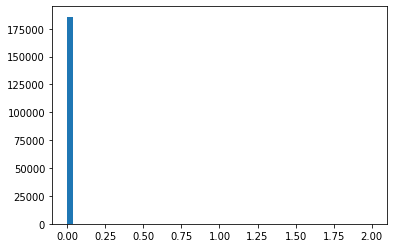

In [ ]:
plt.hist(client['num_atend_atrs'], bins=50)

Função para aplicar a fórmula matemática de normalização nas linhas de cada coluna.

In [ ]:
def normalizeColumn(dataFrame, columnName): 
  return (dataFrame[columnName] - dataFrame[columnName].min()) / (dataFrame[columnName].max() - dataFrame[columnName].min()) 

## Cliente


Colunas do dataframe de cliente a serem normalizadas

In [ ]:
clientNormalizeColumns = ['vlr_credito', 'vlr_saldo', 'num_atend_atrs', 
       'num_produtos', 'num_atend', 'qtd_oper', 'qtd_reclm', 'qtd_restr',
       'vlr_renda']

Normalização de cada coluna

In [ ]:
for column in clientNormalizeColumns:
  client[column] = normalizeColumn(client, column)

Ao visualizar um gráfico de distribuição da coluna vlr_score, percebemos que essa coluna já possui uma distribuição normal. Por isso, na próxima célula fazemos uma padronização dessa feature.

In [ ]:
from sklearn.preprocessing import StandardScaler
client[['vlr_score']] = StandardScaler().fit_transform(client[['vlr_score']])

Visualização do dataframe com as colunas normalizadas e padronizadas.

In [ ]:
client.head(5)

,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj
0,0.001802,0.001837,0.0,0.489887,0.000000,0.0,0.030189,0.0,0.055046,0.003889,0.0,0.0
18,0.000432,0.000086,0.0,-1.685013,0.000000,0.0,0.011321,0.0,0.009174,0.002361,0.0,0.0
30,0.002952,0.001706,0.0,-0.290846,0.011494,0.0,0.045283,0.0,0.036697,0.005001,0.0,0.0
35,0.000083,0.001889,0.0,0.190142,0.000000,0.0,0.022642,0.0,0.009174,0.011529,0.0,0.0
85,0.014023,0.000945,0.0,-0.402379,0.000000,0.0,0.116981,0.0,0.027523,0.011113,0.0,0.0


## Não cliente


Colunas do dataframe de cliente a serem normalizadas

In [ ]:
not_client_normalize_columns = ['vlr_credito', 'num_atend_atrs', 'num_atend', 'qtd_reclm',
       'qtd_restr', 'vlr_renda']

Normalização de cada coluna

In [ ]:
for column in not_client_normalize_columns:
  not_client[column] = normalizeColumn(not_client, column)

Ao visualizar um gráfico de distribuição da coluna vlr_score, percebemos que essa coluna já possui uma distribuição normal. Por isso, na próxima célula fazemos uma padronização dessa feature.

In [ ]:
from sklearn.preprocessing import StandardScaler
not_client[['vlr_score']] = StandardScaler().fit_transform(not_client[['vlr_score']])

Visualização do dataframe com as colunas normalizadas e padronizadas.

In [ ]:
not_client.head()

,vlr_credito,num_atend_atrs,vlr_score,num_atend,qtd_reclm,qtd_restr,vlr_renda,ind_novo_cli
152,0.000100,0.0,1.607560,0.0,0.0,0.00000,0.002846,1.0
209,0.000000,0.0,-0.876154,0.0,0.0,0.00463,0.020181,0.0
891,0.000220,0.0,-0.778900,0.0,0.0,0.00463,0.001294,0.0
1033,0.000565,0.0,2.198564,0.0,0.0,0.00000,0.016300,1.0
1167,0.000000,0.0,-1.003332,0.0,0.0,0.00000,0.004916,0.0


# Salvando a base de dados manipulada em novos arquivos csv
Aqui, salvamos os dataframes tratados no Google Drive para que possamos ter uma base de dados já tratada para o treinamento dos modelos

Salvando um arquivo client.csv

In [ ]:
# Importamos a biblioteca drive do google.colab
from google.colab import drive
         
# Caminhos para o upload
drive.mount(r'/content/drive')
path = r'/content/drive/My Drive/Pandevs/client.csv'

# Salvando o dataframe de não cliente no nosso drive para utilizarmos nos nossos notebooks de modelos
with open(path, 'w', encoding = 'utf-8-sig') as f:
  client.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Salvando um arquivo not_client.csv

In [ ]:
# Caminhos para o upload
drive.mount(r'/content/drive')
path = r'/content/drive/My Drive/Pandevs/not_client.csv'

# Salvando o dataframe de não cliente no nosso drive para utilizarmos nos nossos notebooks de modelos
with open(path, 'w', encoding = 'utf-8-sig') as f:
  not_client.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
